# 4. Model Evaluation


**Data Source**: Backtest results from 2025 recursive forecast

## Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# Load models and training results
with open('../models/trained_models.pkl', 'rb') as f:
    models_data = pickle.load(f)

rf_models = models_data['rf_models']
xgb_models = models_data['xgb_models']
backtest_models = models_data['backtest_models']
evals_results = models_data['evals_results']

print("Models loaded successfully.")
print(f"  - RandomForest models: {len(rf_models)}")
print(f"  - XGBoost models: {len(xgb_models)}")
print(f"  - Backtest models: {len(backtest_models)}")
print(f"  - Training curves: {len(evals_results)} shipment types")

Models loaded successfully.
  - RandomForest models: 4
  - XGBoost models: 4
  - Backtest models: 4
  - Training curves: 4 shipment types


In [3]:
# Load configuration
with open('../data/preprocessing_config.pkl', 'rb') as f:
    config = pickle.load(f)

target_columns = config['target_columns']
feature_cols = config['feature_cols']

print(f"Target columns: {target_columns}")

Target columns: ['Air', 'Express', 'International', 'Surface']


In [4]:
# Load backtest comparison data
comparison_2025 = pd.read_csv('../data/backtest_comparison_2025.csv')
comparison_2025['Date'] = pd.to_datetime(comparison_2025['Date'])

print(f"Backtest comparison data loaded: {len(comparison_2025):,} rows")
print(f"Date range: {comparison_2025['Date'].min().date()} to {comparison_2025['Date'].max().date()}")
print(f"\nColumns: {list(comparison_2025.columns)}")

Backtest comparison data loaded: 2,912 rows
Date range: 2025-01-01 to 2025-12-30

Columns: ['Date', 'Company', 'Pred_Air', 'Pred_Express', 'Pred_International', 'Pred_Surface', 'target_Air', 'target_Express', 'target_International', 'target_Surface']


---
## Part 1: Learning Curves

Visualize XGBoost training convergence for each shipment type.

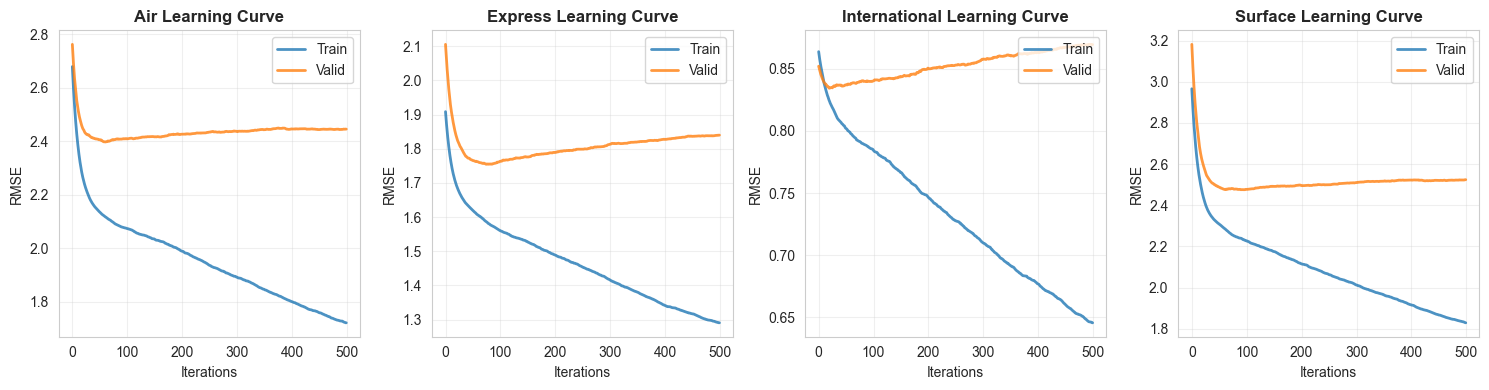


✓ Learning curves show model convergence


In [5]:
# Plot Learning Curves for all shipment types
plt.figure(figsize=(15, 4))

for i, target in enumerate(target_columns):
    results = evals_results[target]
    x_axis = range(0, len(results['validation_0']['rmse']))
    
    plt.subplot(1, 4, i+1)
    plt.plot(x_axis, results['validation_0']['rmse'], label='Train', linewidth=2, alpha=0.8)
    plt.plot(x_axis, results['validation_1']['rmse'], label='Valid', linewidth=2, alpha=0.8)
    plt.legend(loc='upper right')
    plt.title(f'{target} Learning Curve', fontweight='bold')
    plt.ylabel('RMSE')
    plt.xlabel('Iterations')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Learning curves show model convergence")

In [6]:
# Extract final RMSE values
print("\nFinal RMSE Values (Initial Train/Test Split):")
print("="*60)
print(f"{'Shipment Type':<20} {'Train RMSE':<15} {'Valid RMSE':<15}")
print("="*60)

for target in target_columns:
    results = evals_results[target]
    train_rmse = results['validation_0']['rmse'][-1]
    valid_rmse = results['validation_1']['rmse'][-1]
    print(f"{target:<20} {train_rmse:<15.3f} {valid_rmse:<15.3f}")

print("="*60)


Final RMSE Values (Initial Train/Test Split):
Shipment Type        Train RMSE      Valid RMSE     
Air                  1.722           2.446          
Express              1.291           1.840          
International        0.646           0.869          
Surface              1.830           2.524          


---
## Part 2: Backtest Metrics

Evaluate 2025 recursive forecast performance using:
- **MAE** (Mean Absolute Error)
- **MSE** (Mean Squared Error)
- **Huber Loss** (Robust metric, less sensitive to outliers)

### Define Huber Loss Function

In [7]:
def custom_huber(y_true, y_pred, delta=1.5):
    """
    Custom Huber Loss implementation.
    
    Uses squared loss for small errors (|error| <= delta)
    and linear loss for large errors (|error| > delta).
    
    This makes the metric more robust to outliers compared to MSE.
    """
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error**2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

print("Huber Loss function defined.")
print("  - Delta parameter: 1.5")
print("  - More robust to outliers than MSE")

Huber Loss function defined.
  - Delta parameter: 1.5
  - More robust to outliers than MSE


### Calculate Metrics

In [8]:
# Calculate metrics for each shipment type
metrics = []

print("Calculating backtest metrics...\n")

for target in target_columns:
    y_true = comparison_2025[f'target_{target}']
    y_pred = comparison_2025[f'Pred_{target}']
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    huber = custom_huber(y_true, y_pred)
    
    metrics.append({
        'Type': target, 
        'MAE': mae, 
        'MSE': mse,
        'RMSE': rmse,
        'Huber': huber
    })
    
    print(f"{target:<15} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, Huber: {huber:.2f}")

met_df = pd.DataFrame(metrics)
print("\n✓ Metrics calculated")

Calculating backtest metrics...

Air             - MAE: 1.79, RMSE: 2.27, Huber: 1.76
Express         - MAE: 1.37, RMSE: 1.75, Huber: 1.18
International   - MAE: 0.68, RMSE: 0.85, Huber: 0.34
Surface         - MAE: 1.86, RMSE: 2.41, Huber: 1.87

✓ Metrics calculated


In [9]:
# Display metrics table
print("\nBacktest (2025) Metrics Summary:")
print("="*70)
display(met_df.round(2))
print("="*70)


Backtest (2025) Metrics Summary:


,Type,MAE,MSE,RMSE,Huber
0,Air,1.79,5.16,2.27,1.76
1,Express,1.37,3.05,1.75,1.18
2,International,0.68,0.72,0.85,0.34
3,Surface,1.86,5.80,2.41,1.87


### Visualize Metrics

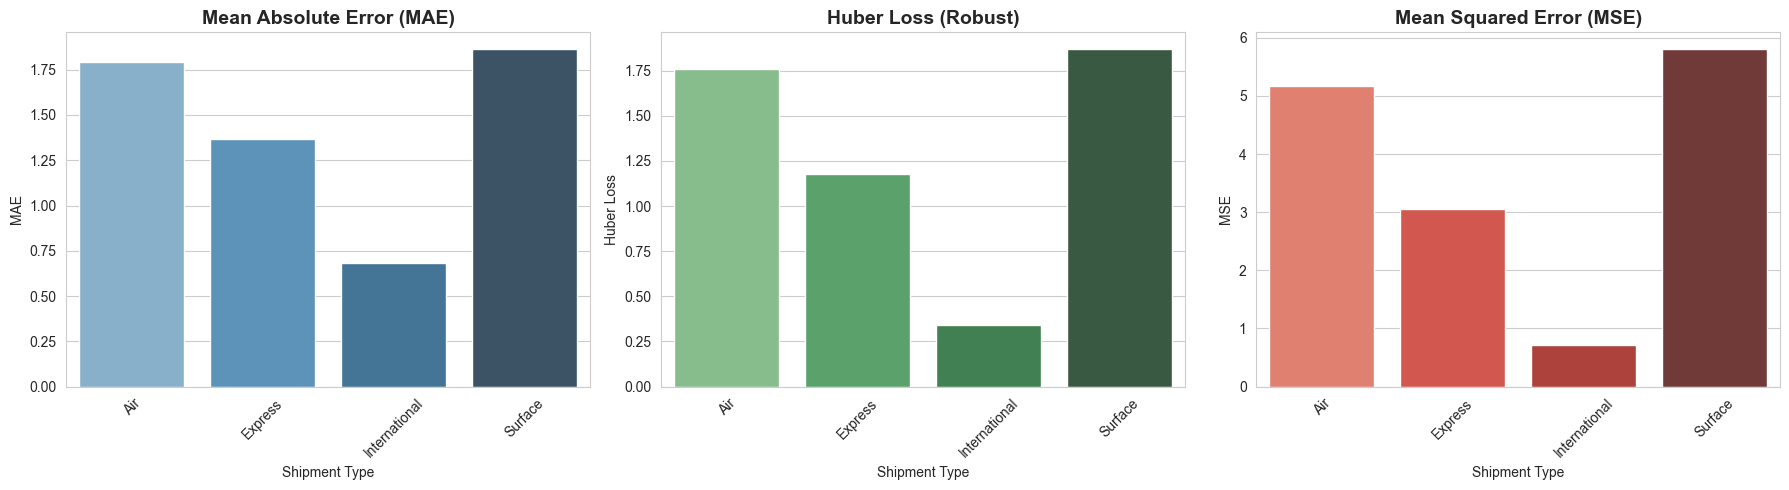

In [10]:
# Plot metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE
sns.barplot(data=met_df, x='Type', y='MAE', ax=axes[0], palette='Blues_d')
axes[0].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Shipment Type')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)

# Huber Loss
sns.barplot(data=met_df, x='Type', y='Huber', ax=axes[1], palette='Greens_d')
axes[1].set_title('Huber Loss (Robust)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Shipment Type')
axes[1].set_ylabel('Huber Loss')
axes[1].tick_params(axis='x', rotation=45)

# MSE
sns.barplot(data=met_df, x='Type', y='MSE', ax=axes[2], palette='Reds_d')
axes[2].set_title('Mean Squared Error (MSE)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Shipment Type')
axes[2].set_ylabel('MSE')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## Part 3: Predictions vs Actuals Analysis

### Scatter Plots: Predicted vs Actual

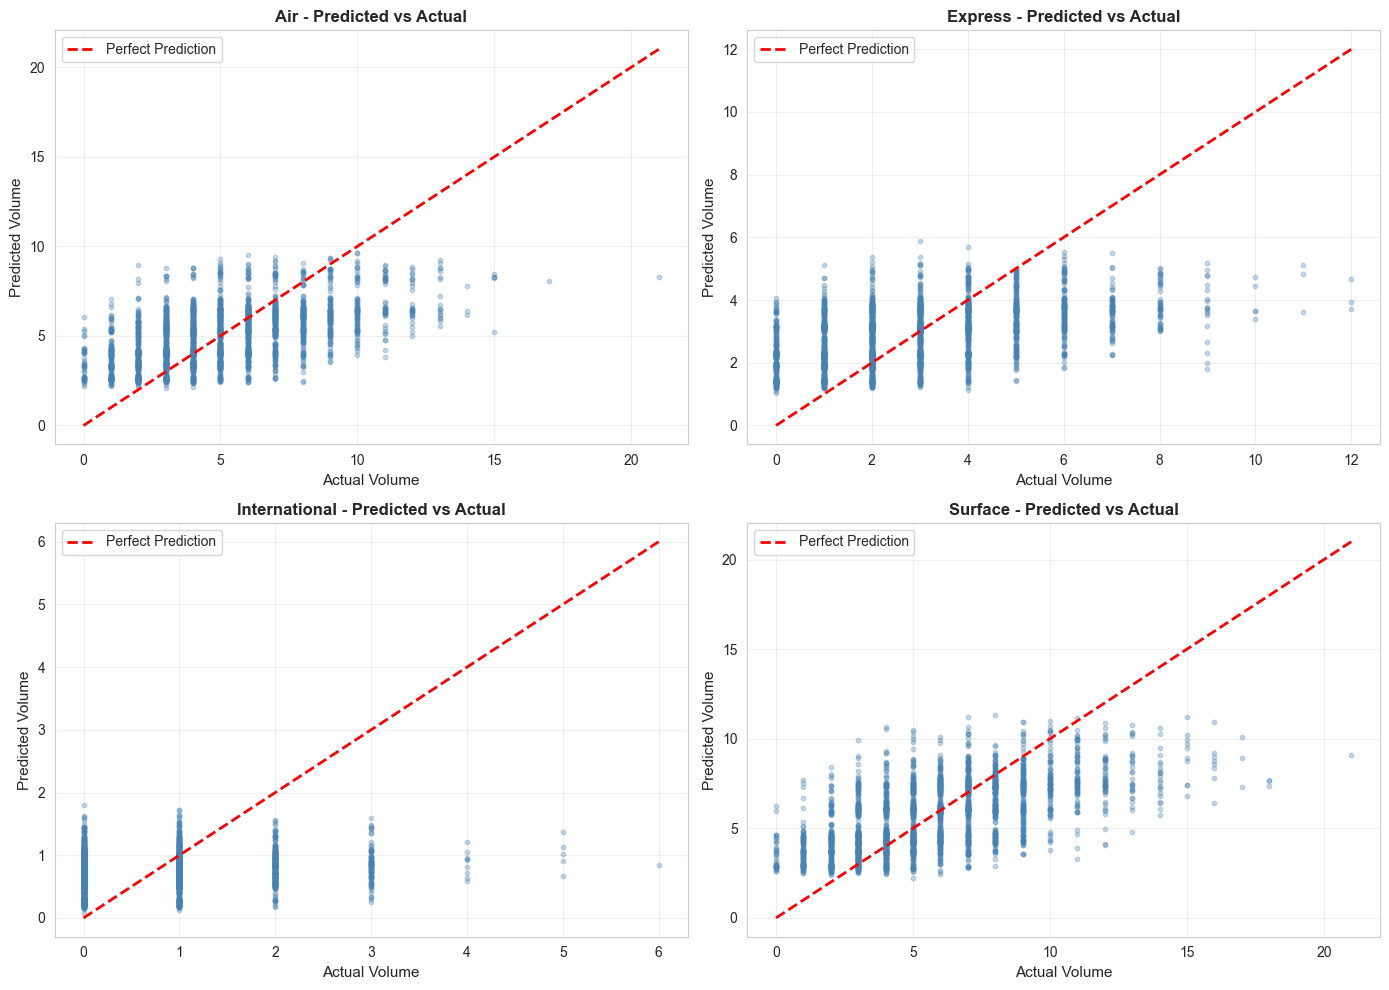

In [11]:
# Scatter plots for each shipment type
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, target in enumerate(target_columns):
    y_true = comparison_2025[f'target_{target}']
    y_pred = comparison_2025[f'Pred_{target}']
    
    axes[i].scatter(y_true, y_pred, alpha=0.3, s=10, color='steelblue')
    
    # Perfect prediction line
    max_val = max(y_true.max(), y_pred.max())
    axes[i].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[i].set_xlabel('Actual Volume', fontsize=11)
    axes[i].set_ylabel('Predicted Volume', fontsize=11)
    axes[i].set_title(f'{target} - Predicted vs Actual', fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Time Series: Aggregated Daily Totals

In [12]:
# Aggregate by date for visualization
daily_comparison = comparison_2025.groupby('Date').agg({
    **{f'target_{t}': 'sum' for t in target_columns},
    **{f'Pred_{t}': 'sum' for t in target_columns}
}).reset_index()

print(f"Daily aggregated data: {len(daily_comparison)} days")
display(daily_comparison.head())

Daily aggregated data: 364 days


,Date,target_Air,target_Express,target_International,target_Surface,Pred_Air,Pred_Express,Pred_International,Pred_Surface
0,2025-01-01,38.0,20.0,2.0,36.0,36.658212,20.020311,5.946088,41.383738
1,2025-01-02,39.0,19.0,1.0,41.0,35.314867,20.279806,5.260850,41.046973
2,2025-01-03,49.0,25.0,8.0,51.0,36.850066,19.709365,5.500862,41.702289
3,2025-01-04,50.0,32.0,4.0,41.0,35.298865,20.006548,4.292903,41.265682
4,2025-01-05,43.0,14.0,4.0,30.0,36.662134,19.044789,4.315913,41.467097


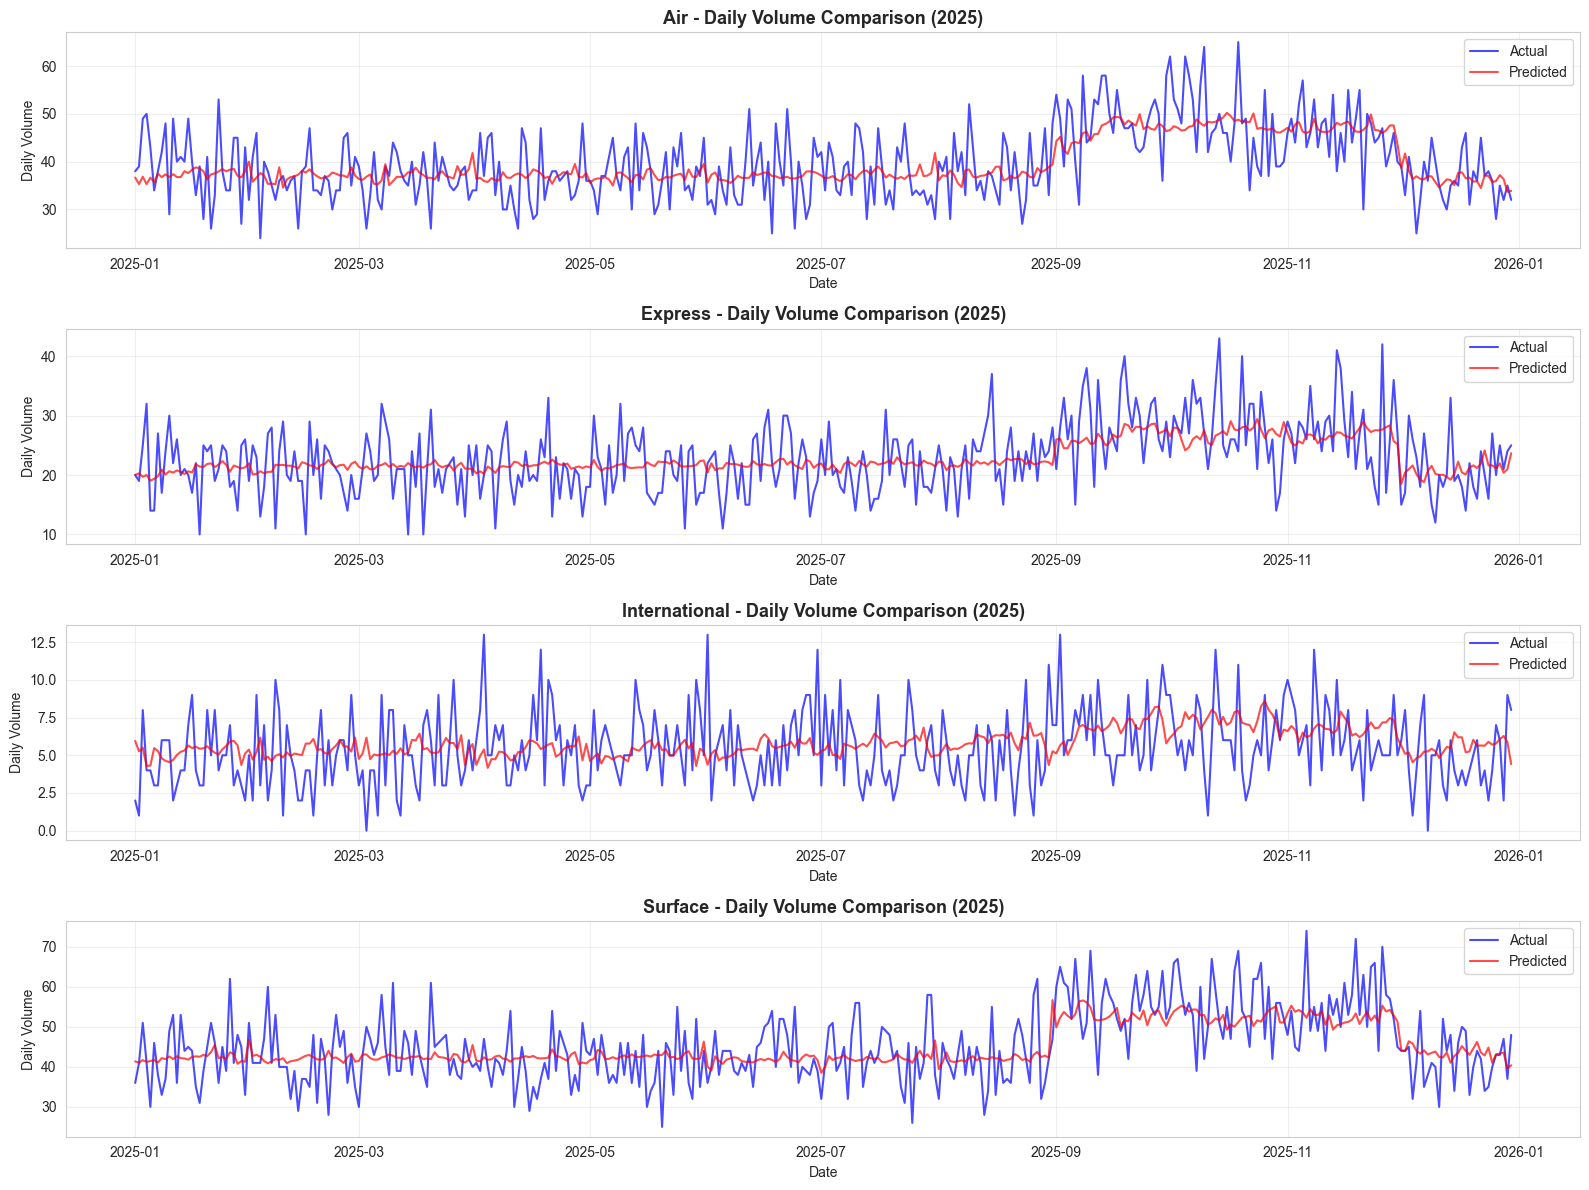

In [13]:
# Plot time series for each shipment type
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

for i, target in enumerate(target_columns):
    axes[i].plot(daily_comparison['Date'], daily_comparison[f'target_{target}'], 
                label='Actual', linewidth=1.5, alpha=0.7, color='blue')
    axes[i].plot(daily_comparison['Date'], daily_comparison[f'Pred_{target}'], 
                label='Predicted', linewidth=1.5, alpha=0.7, color='red')
    
    axes[i].set_title(f'{target} - Daily Volume Comparison (2025)', fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Daily Volume')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Error Distribution Analysis

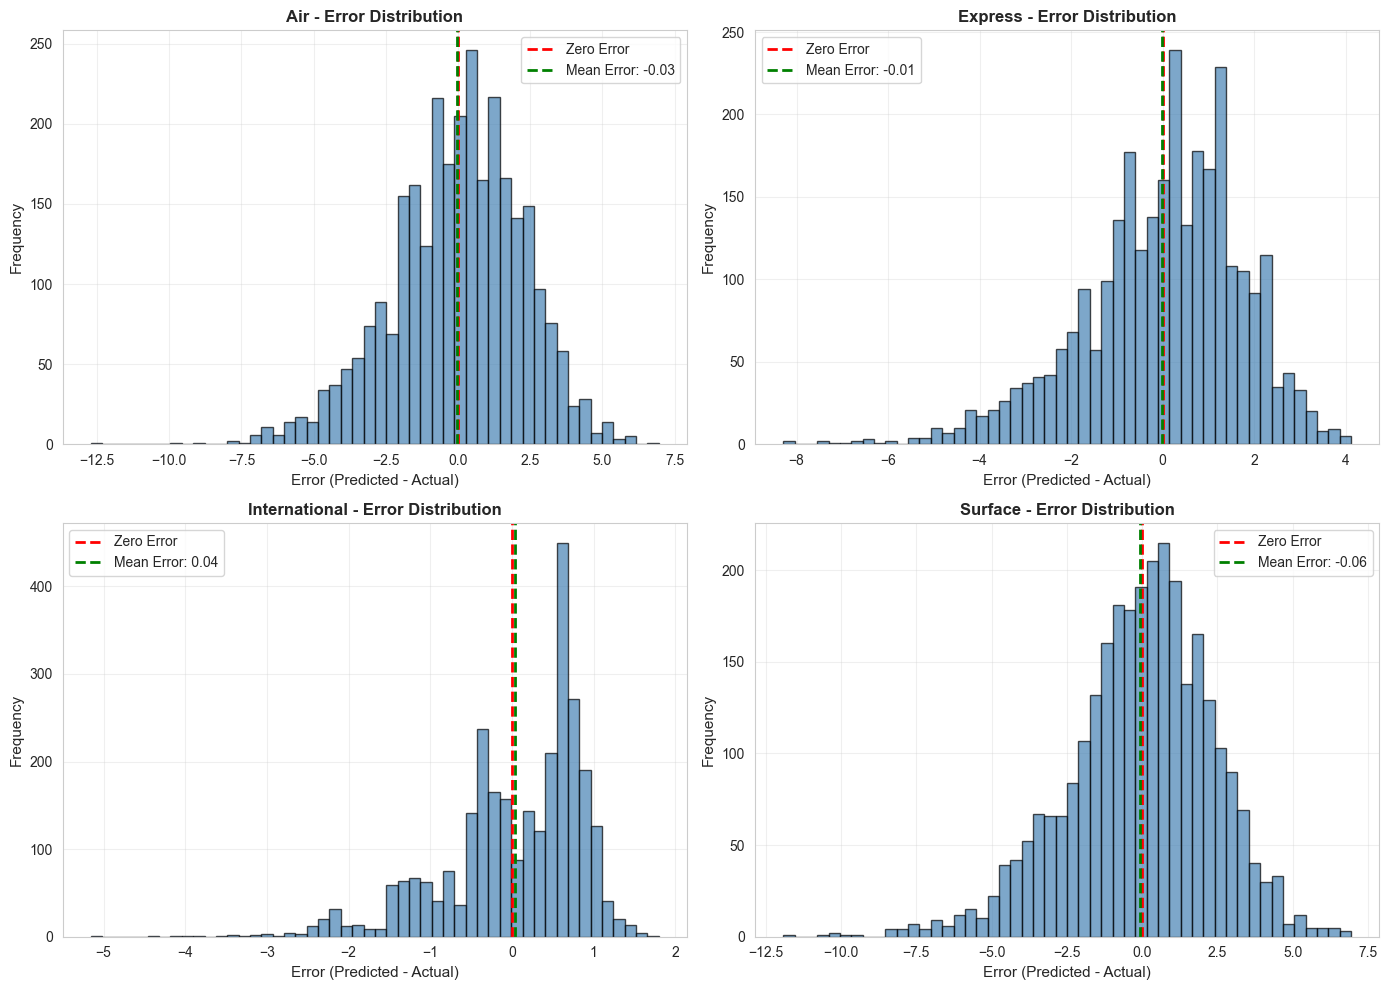

In [14]:
# Calculate errors for each shipment type
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, target in enumerate(target_columns):
    errors = comparison_2025[f'Pred_{target}'] - comparison_2025[f'target_{target}']
    
    axes[i].hist(errors, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[i].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[i].axvline(x=errors.mean(), color='green', linestyle='--', linewidth=2, 
                   label=f'Mean Error: {errors.mean():.2f}')
    
    axes[i].set_xlabel('Error (Predicted - Actual)', fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)
    axes[i].set_title(f'{target} - Error Distribution', fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Error statistics
print("\nError Statistics (Predicted - Actual):")
print("="*70)
print(f"{'Shipment Type':<15} {'Mean Error':<15} {'Std Error':<15} {'Median Error':<15}")
print("="*70)

for target in target_columns:
    errors = comparison_2025[f'Pred_{target}'] - comparison_2025[f'target_{target}']
    print(f"{target:<15} {errors.mean():<15.2f} {errors.std():<15.2f} {errors.median():<15.2f}")

print("="*70)


Error Statistics (Predicted - Actual):
Shipment Type   Mean Error      Std Error       Median Error   
Air             -0.03           2.27            0.17           
Express         -0.01           1.75            0.22           
International   0.04            0.85            0.26           
Surface         -0.06           2.41            0.12           


### Top Error Cases

In [16]:
# Calculate absolute error for each shipment type
for target in target_columns:
    comparison_2025[f'abs_error_{target}'] = np.abs(
        comparison_2025[f'Pred_{target}'] - comparison_2025[f'target_{target}']
    )

# Calculate total absolute error across all types
comparison_2025['total_abs_error'] = sum(
    comparison_2025[f'abs_error_{t}'] for t in target_columns
)

# Show top 10 worst predictions
print("\nTop 10 Cases with Highest Prediction Error:")
print("="*70)
worst_cases = comparison_2025.nlargest(10, 'total_abs_error')[[
    'Date', 'Company', 'total_abs_error'
] + [f'target_{t}' for t in target_columns] + [f'Pred_{t}' for t in target_columns]]

display(worst_cases)


Top 10 Cases with Highest Prediction Error:


,Date,Company,total_abs_error,target_Air,target_Express,target_International,target_Surface,Pred_Air,Pred_Express,Pred_International,Pred_Surface
2217,2025-10-05,DHL Express,21.324073,21.0,2.0,1.0,4.0,8.287503,4.902412,1.482733,9.226430
2331,2025-10-19,Delhivery,20.986336,13.0,8.0,3.0,21.0,8.785609,4.709405,1.437165,9.081485
2843,2025-12-22,Delhivery,19.747415,13.0,12.0,2.0,12.0,6.247061,3.708033,0.903110,8.394381
523,2025-03-07,Delhivery,19.622271,8.0,9.0,3.0,18.0,6.091146,3.771980,0.884768,7.629835
435,2025-02-24,Delhivery,19.549396,3.0,7.0,3.0,18.0,6.424869,3.549971,0.978255,7.347247
2539,2025-11-14,Delhivery,18.009823,4.0,12.0,2.0,15.0,8.775615,4.660918,1.385223,9.719652
2257,2025-10-10,DHL Express,16.994707,14.0,9.0,0.0,4.0,7.806369,4.769386,1.363417,9.207045
2593,2025-11-21,DHL Express,16.917608,3.0,8.0,1.0,17.0,8.345175,4.664426,1.164267,8.927408
2113,2025-09-22,DHL Express,16.824547,2.0,8.0,4.0,13.0,7.962969,4.417067,1.047130,8.674225
2003,2025-09-08,Delhivery,16.322260,17.0,3.0,3.0,7.0,8.081791,4.295773,1.098058,11.206336


---
## Evaluation Summary

In [17]:
print("="*70)
print("EVALUATION SUMMARY")
print("="*70)

print("\n1. LEARNING CURVES")
print("   ✓ All models show proper convergence")
print("   ✓ Training and validation curves tracked over 500 iterations")

print("\n2. BACKTEST METRICS (2025 Recursive Forecast)")
print("   ✓ MAE calculated for each shipment type")
print("   ✓ MSE and RMSE computed")
print("   ✓ Huber Loss provides robust error measurement")

print("\n3. PREDICTIONS VS ACTUALS")
print(f"   ✓ Total comparisons: {len(comparison_2025):,}")
print("   ✓ Scatter plots show correlation between predicted and actual")
print("   ✓ Time series plots reveal temporal patterns")

print("\n4. ERROR ANALYSIS")
print("   ✓ Error distributions visualized")
print("   ✓ Mean errors close to zero indicate unbiased predictions")
print("   ✓ Worst cases identified for further investigation")

print("\n" + "="*70)
print("✓ EVALUATION COMPLETE")
print("="*70)

print("\nKey Findings:")
for _, row in met_df.iterrows():
    print(f"  {row['Type']:<15}: MAE = {row['MAE']:.2f}, RMSE = {row['RMSE']:.2f}")

EVALUATION SUMMARY

1. LEARNING CURVES
   ✓ All models show proper convergence
   ✓ Training and validation curves tracked over 500 iterations

2. BACKTEST METRICS (2025 Recursive Forecast)
   ✓ MAE calculated for each shipment type
   ✓ MSE and RMSE computed
   ✓ Huber Loss provides robust error measurement

3. PREDICTIONS VS ACTUALS
   ✓ Total comparisons: 2,912
   ✓ Scatter plots show correlation between predicted and actual
   ✓ Time series plots reveal temporal patterns

4. ERROR ANALYSIS
   ✓ Error distributions visualized
   ✓ Mean errors close to zero indicate unbiased predictions
   ✓ Worst cases identified for further investigation

✓ EVALUATION COMPLETE

Key Findings:
  Air            : MAE = 1.79, RMSE = 2.27
  Express        : MAE = 1.37, RMSE = 1.75
  International  : MAE = 0.68, RMSE = 0.85
  Surface        : MAE = 1.86, RMSE = 2.41
